In [53]:
# Import des bibliothèques nécessaires pour l'analyse et le deep learning

# Bibliothèques de manipulation de données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Métriques et évaluation
from sklearn.metrics import accuracy_score, classification_report

# TensorFlow et Keras pour le deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [54]:
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Carga de datos:
Objetivo: Importar los datos del archivo CSV filtered_data_final.csv a un DataFrame de Pandas. Explicación: El código primero verifica la existencia del archivo antes de cargarlo. Si existe, utiliza pd.read_csv para importar los datos. Resultado: Se crea un DataFrame data que contiene los datos y se muestran las 5 primeras filas.

In [56]:
# Importation de pandas pour la manipulation des données
import os

# Définir le chemin du fichier
file_path = "/content/drive/MyDrive/DeepLearning/filtered_data_final.csv"

# Vérification de l'existence du fichier avant de le charger
if os.path.exists(file_path):
    # Chargement des données avec pandas
    data = pd.read_csv(file_path, sep=';')  # Lecture du fichier CSV avec un séparateur ';'
    print(f"Le fichier a été chargé avec succès. Dimensions du DataFrame : {data.shape}")

    # Affichage des 5 premières lignes du DataFrame pour inspection
    print(data.head())
else:
    print(f"Erreur : le fichier {file_path} n'a pas été trouvé.")


Le fichier a été chargé avec succès. Dimensions du DataFrame : (7199, 72)
      id                         listing_url       scrape_id last_scraped  \
0   3781   https://www.airbnb.com/rooms/3781  20231218233145   2023-12-19   
1   5506   https://www.airbnb.com/rooms/5506  20231218233145   2023-12-19   
2   6695   https://www.airbnb.com/rooms/6695  20231218233145   2023-12-19   
3   8789   https://www.airbnb.com/rooms/8789  20231218233145   2023-12-19   
4  10813  https://www.airbnb.com/rooms/10813  20231218233145   2023-12-19   

        source                                        picture_url  host_id  \
0  city scrape  https://a0.muscache.com/pictures/24670/b2de044...     4804   
1  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...     8229   
2  city scrape  https://a0.muscache.com/pictures/38ac4797-e7a4...     8229   
3  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...    26988   
4  city scrape  https://a0.muscache.com/pictures/20b5b9c9-e1f4...    3899

# 2. Dividir en conjuntos de entrenamiento, validación y prueba:
Objetivo: Dividir los datos en tres conjuntos: entrenamiento, validación y prueba. Explicación: El código utiliza train_test_split de scikit-learn para realizar la división. Resultado: Se crean tres DataFrames: train, validation y test con el 60%, 20% y 20% de los datos, respectivamente.

In [57]:
# Diviser les données en ensemble d'entraînement+validation (80%) et ensemble de test (20%)
train_val, test = train_test_split(data, test_size=0.2, random_state=42)
print(f"Taille du jeu de test : {test.shape}")

# Diviser l'ensemble d'entraînement+validation en un jeu d'entraînement (60%) et un jeu de validation (20%)
# 0.25 x 0.8 = 0.20 du dataset original
train, validation = train_test_split(train_val, test_size=0.25, random_state=42)
print(f"Taille du jeu d'entraînement : {train.shape}")
print(f"Taille du jeu de validation : {validation.shape}")


Taille du jeu de test : (1440, 72)
Taille du jeu d'entraînement : (4319, 72)
Taille du jeu de validation : (1440, 72)


# 3. Aplicar transformaciones y limpieza:

Objetivo: Preparar los datos para el Machine Learning realizando transformaciones y limpiando los datos. Explicación: Se llevan a cabo varios pasos: - Limpieza de la columna price (eliminación de símbolos y conversión a numérico). - Gestión de valores faltantes en la columna price (relleno con la mediana). - Categorización de precios en tres grupos (bajo, medio, alto) utilizando los percentiles calculados en el conjunto de entrenamiento. - Extracción del número de baños de la columna bathrooms_text. - Eliminación de columnas irrelevantes para la predicción. Resultado: Se crean DataFrames limpios train_cleaned, validation_cleaned y test_cleaned.


Distribution des groupes de prix dans l'ensemble d'entraînement pour la colonne 'price_group_balanced':
price_group_balanced
0    1465
1    1418
2    1436
Name: count, dtype: int64

Pourcentages des groupes de prix dans l'ensemble d'entraînement :
price_group_balanced
0    33.919889
1    32.831674
2    33.248437
Name: proportion, dtype: float64


<ipython-input-58-75e9549f1163>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[colonne].fillna(mediane, inplace=True)


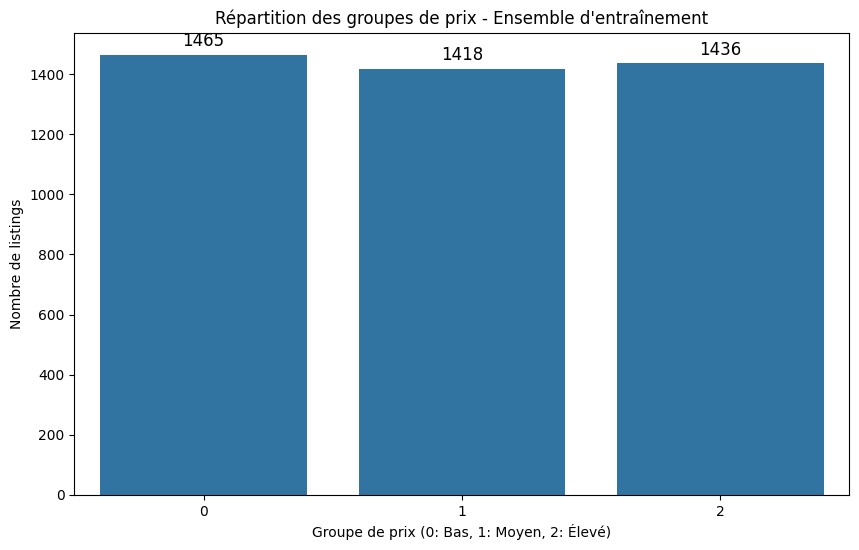


Plages de prix pour chaque catégorie - Ensemble d'entraînement :
                        min      max
price_group_balanced                
0                      25.0     98.0
1                      99.0    175.0
2                     176.0  10000.0


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que train, validation, et test sont déjà définis.

# 1. Nettoyage de la colonne 'price' : suppression des symboles monétaires et des virgules
def nettoyer_prix(prix):
    """
    Nettoie les valeurs de la colonne 'price' en supprimant les symboles monétaires et les virgules.
    """
    prix = str(prix).replace('$', '').replace('€', '').replace(',', '')  # Retirer les symboles et virgules
    return prix

# Appliquer la fonction de nettoyage à la colonne 'price' pour chaque dataset
for dataset in [train, validation, test]:
    dataset['price'] = dataset['price'].apply(nettoyer_prix)

# 2. Convertir la colonne 'price' en numérique, en gérant les erreurs avec 'coerce'
def convertir_en_numerique(df, colonne):
    """
    Convertit la colonne spécifiée d'un DataFrame en valeurs numériques, en remplaçant les valeurs
    non convertibles par NaN.
    """
    df[colonne] = pd.to_numeric(df[colonne], errors='coerce')  # Remplacer les valeurs non convertibles par NaN

# Appliquer la conversion à la colonne 'price' pour chaque dataset
for dataset in [train, validation, test]:
    convertir_en_numerique(dataset, 'price')

# 3. Gérer les valeurs manquantes : remplissage des NaN avec la médiane
def remplir_valeurs_manquantes(df, colonne):
    """
    Remplit les valeurs manquantes d'une colonne avec la médiane de cette colonne.
    """
    mediane = df[colonne].median()
    df[colonne].fillna(mediane, inplace=True)

# Appliquer le remplissage des NaN à la colonne 'price' pour chaque dataset
for dataset in [train, validation, test]:
    remplir_valeurs_manquantes(dataset, 'price')

# 4. Calcul des percentiles pour la catégorisation des prix
def calculer_percentiles(df, colonne, percentiles=[34, 67]):
    """
    Calcule les percentiles spécifiés pour une colonne donnée dans un DataFrame.
    """
    return np.percentile(df[colonne], percentiles)

# Calculer les percentiles 34 et 67 pour la colonne 'price' dans l'ensemble d'entraînement
q34, q67 = calculer_percentiles(train, 'price')

# 5. Catégorisation des prix en trois groupes : Bas, Moyen, Élevé
def categoriser_prix(prix, q34, q67):
    """
    Catégorise les prix en trois groupes : Bas (0), Moyen (1), Élevé (2).
    """
    if prix < q34:
        return 0  # Bas
    elif q34 <= prix < q67:
        return 1  # Moyen
    else:
        return 2  # Élevé

# Appliquer la catégorisation des prix à chaque dataset
for dataset in [train, validation, test]:
    dataset['price_group_balanced'] = dataset['price'].apply(categoriser_prix, args=(q34, q67))

# 6. Affichage des résultats pour l'ensemble d'entraînement
def afficher_distributions(df, colonne):
    """
    Affiche la distribution des valeurs de la colonne spécifiée (comptage et pourcentage).
    """
    print(f"\nDistribution des groupes de prix dans l'ensemble d'entraînement pour la colonne '{colonne}':")
    print(df[colonne].value_counts().sort_index())  # Comptage des groupes
    print("\nPourcentages des groupes de prix dans l'ensemble d'entraînement :")
    print(df[colonne].value_counts(normalize=True).sort_index() * 100)  # Pourcentages

# Afficher la distribution des groupes de prix pour l'ensemble d'entraînement
afficher_distributions(train, 'price_group_balanced')

# 7. Visualisation de la distribution des groupes de prix
def visualiser_distribution(df, colonne):
    """
    Crée un graphique de distribution pour la colonne spécifiée.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x=colonne, data=df, order=[0, 1, 2])  # Organiser les groupes de prix
    plt.title('Répartition des groupes de prix - Ensemble d\'entraînement')
    plt.xlabel('Groupe de prix (0: Bas, 1: Moyen, 2: Élevé)')
    plt.ylabel('Nombre de listings')

    # Ajouter les valeurs exactes sur le graphique
    for i, v in enumerate(df[colonne].value_counts().sort_index()):
        plt.text(i, v + 30, str(v), ha='center', fontsize=12)

    plt.show()

# Visualiser la distribution des groupes de prix dans l'ensemble d'entraînement
visualiser_distribution(train, 'price_group_balanced')

# 8. Afficher les plages de prix pour chaque catégorie dans l'ensemble d'entraînement
def afficher_plages_de_prix(df, colonne):
    """
    Affiche les plages de prix (minimum et maximum) pour chaque groupe de la colonne spécifiée.
    """
    print("\nPlages de prix pour chaque catégorie - Ensemble d'entraînement :")
    print(df.groupby(colonne)['price'].agg(['min', 'max']))  # Plages de prix pour chaque groupe

# Afficher les plages de prix pour chaque catégorie
afficher_plages_de_prix(train, 'price_group_balanced')






In [59]:
import numpy as np
import pandas as pd

def extract_bathrooms(text):
    """
    Extrait le nombre de salles de bains à partir d'un texte donné.
    - Si le texte mentionne 'half-bath', cela renvoie 0.5.
    - Si le texte peut être converti en un nombre (ex. '2.5'), cela renvoie ce nombre.
    - Sinon, retourne np.nan.
    """
    if pd.isna(text):  # Si la valeur est manquante, renvoyer NaN
        return np.nan

    text = text.lower()  # Convertir en minuscule pour éviter les problèmes de casse

    # Cas spécifique pour "half-bath" ou autres mentions similaires
    if 'half-bath' in text or 'half bath' in text:
        return 0.5

    # Cas où le texte est directement convertible en nombre
    try:
        # Extraire le premier mot et le convertir en float
        return float(text.split()[0])
    except (ValueError, IndexError):  # Gérer les erreurs de conversion et de découpe du texte
        return np.nan  # Si la conversion échoue, renvoyer NaN

# Appliquer la fonction à train, validation et test
for dataset in [train, validation, test]:
    dataset['bathrooms'] = dataset['bathrooms_text'].apply(extract_bathrooms)

# Vérification de l'application de la fonction
print(train[['bathrooms_text', 'bathrooms']].head())


     bathrooms_text  bathrooms
3017        2 baths        2.0
1985         1 bath        1.0
4344         1 bath        1.0
5380         1 bath        1.0
4260         1 bath        1.0


In [60]:
# Liste des colonnes à supprimer
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'picture_url', 'host_id', 'host_url',
    'host_thumbnail_url', 'host_picture_url', 'last_scraped', 'source',
    'calendar_last_scraped', 'host_name', 'host_about', 'host_location',
    'host_neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms_text',
    'bedrooms', 'calendar_updated', 'number_of_reviews', 'number_of_reviews_ltm',
    'number_of_reviews_l30d', 'first_review', 'last_review', 'reviews_per_month',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
]

# Fonction pour nettoyer un DataFrame en supprimant les colonnes
def nettoyer_dataframe(df, columns_to_drop):
    """
    Supprime les colonnes spécifiées d'un DataFrame, en s'assurant que ces colonnes existent.
    """
    # Vérification des colonnes présentes dans le DataFrame avant suppression
    cols_presentes = [col for col in columns_to_drop if col in df.columns]
    cols_manquantes = [col for col in columns_to_drop if col not in df.columns]

    if cols_manquantes:
        print(f"Attention : les colonnes suivantes sont manquantes et n'ont pas été supprimées : {cols_manquantes}")

    # Supprimer les colonnes présentes dans le DataFrame
    return df.drop(columns=cols_presentes)

# Appliquer la fonction de nettoyage aux datasets
train_cleaned = nettoyer_dataframe(train, columns_to_drop)
validation_cleaned = nettoyer_dataframe(validation, columns_to_drop)
test_cleaned = nettoyer_dataframe(test, columns_to_drop)

# Vérification de la forme avant et après nettoyage
print("\nForme avant nettoyage (train) :")
print(train.shape)
print("\nForme après nettoyage (train) :")
print(train_cleaned.shape)



Forme avant nettoyage (train) :
(4319, 73)

Forme après nettoyage (train) :
(4319, 44)


Dimensiones de las variables numéricas: (4319, 28)


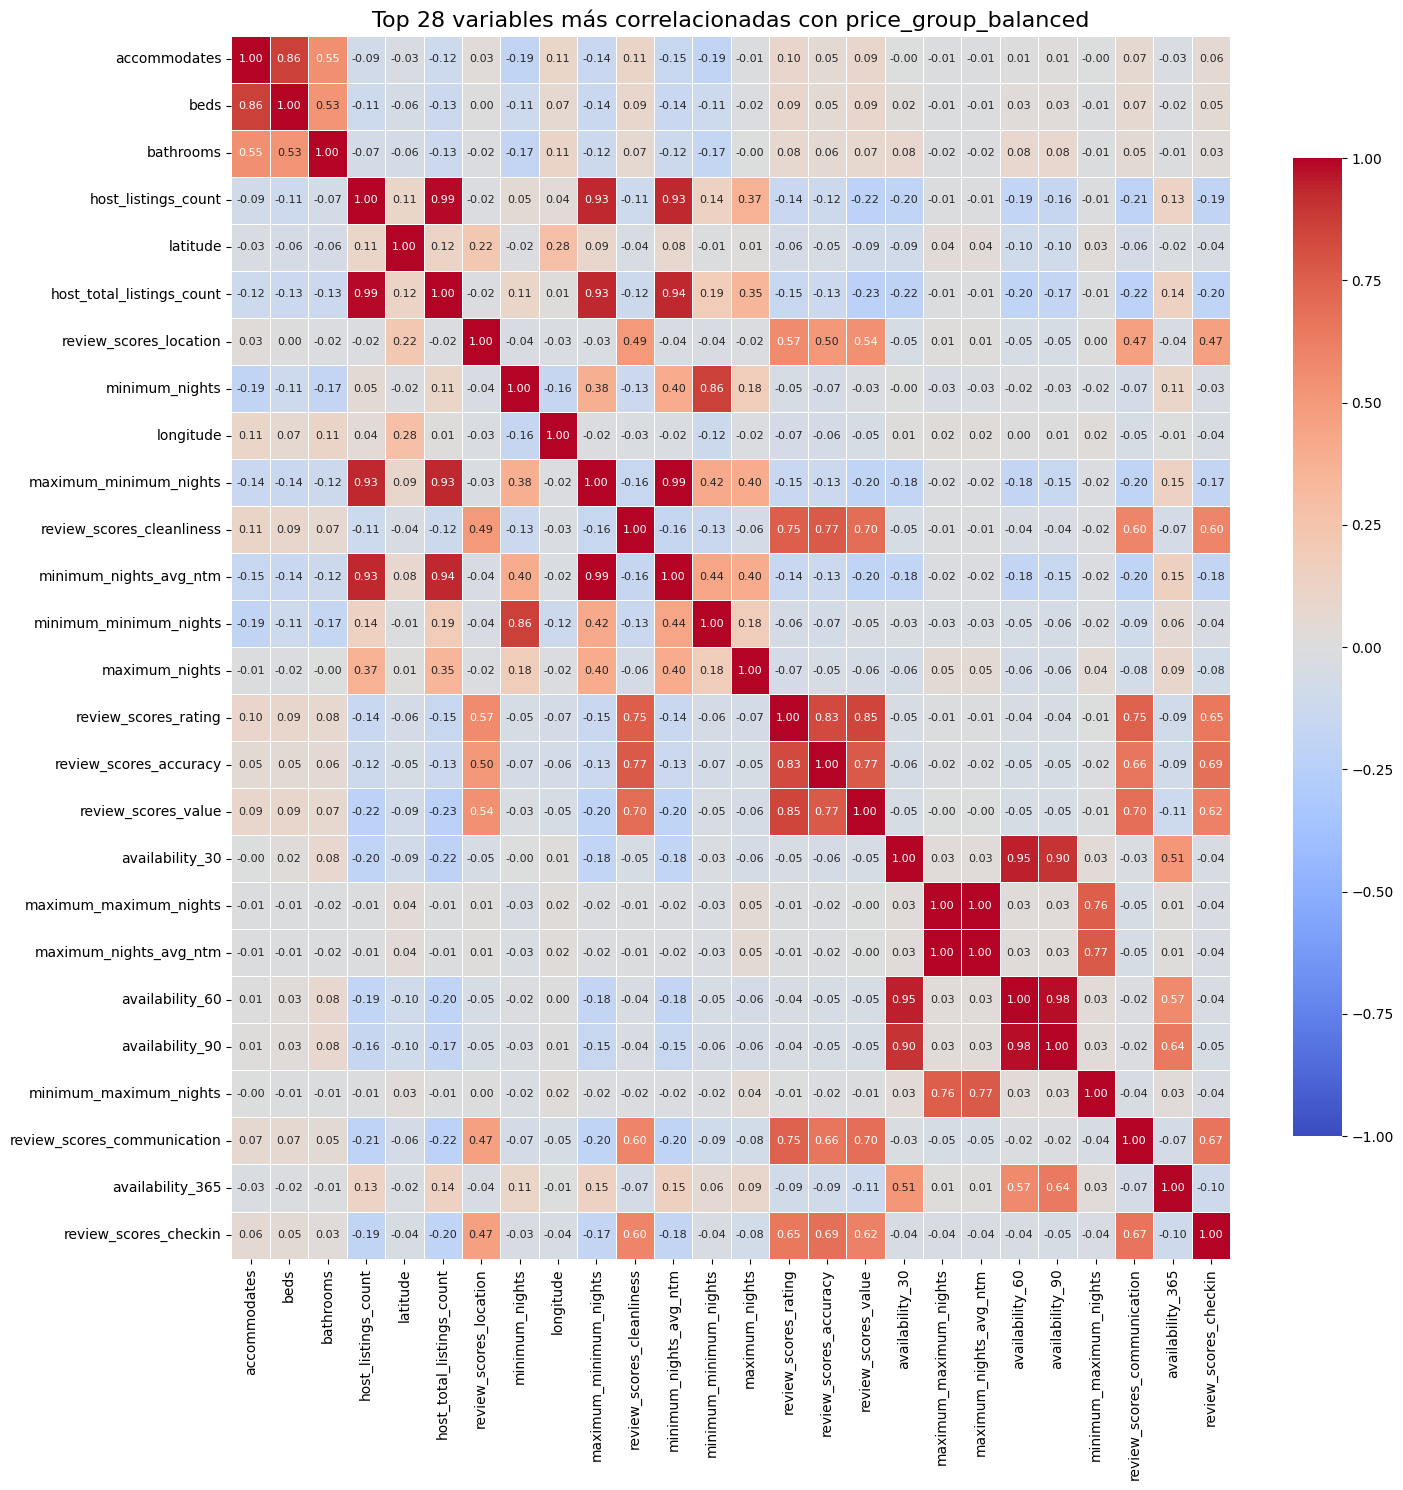


Columnas ordenadas por influencia en 'price_group_balanced' :
price_group_balanced           1.000000
accommodates                   0.543072
beds                           0.415136
price                          0.407878
bathrooms                      0.328506
host_listings_count            0.195283
latitude                       0.176069
host_total_listings_count      0.163565
review_scores_location         0.163071
minimum_nights                 0.157799
longitude                      0.140403
maximum_minimum_nights         0.125781
review_scores_cleanliness      0.123188
minimum_nights_avg_ntm         0.122639
minimum_minimum_nights         0.114451
maximum_nights                 0.105081
review_scores_rating           0.101612
review_scores_accuracy         0.053067
review_scores_value            0.043447
availability_30                0.043411
maximum_maximum_nights         0.042471
maximum_nights_avg_ntm         0.042351
availability_60                0.038781
availability_90  

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar las variables numéricas
numeric = train_cleaned.select_dtypes(include=[np.number])

# Verificar las dimensiones de las variables numéricas
print("Dimensiones de las variables numéricas:", numeric.shape)

# Calcular la matriz de correlación entre las variables numéricas
correlation_matrix = numeric.corr()

# Extraer las correlaciones con la variable 'price_group_balanced'
price_correlations = correlation_matrix['price_group_balanced']

# Obtener las correlaciones absolutas con 'price_group_balanced' y ordenarlas
price_group_correlations = price_correlations.abs().sort_values(ascending=False)

# Definir el número de variables más correlacionadas a mostrar
N = 28  # Ajusta este número según tus necesidades

# Seleccionar las N variables más correlacionadas (excluyendo 'price' y 'price_group_balanced')
top_correlated = price_group_correlations.drop(['price', 'price_group_balanced']).nlargest(N).index

# Crear una submatriz de correlación con las variables más correlacionadas
correlation_subset = correlation_matrix.loc[top_correlated, top_correlated]

# Crear el mapa de calor (heatmap) de correlación
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(correlation_subset,
                      annot=True,             # Mostrar los valores sobre el heatmap
                      cmap='coolwarm',        # Paleta de colores
                      vmin=-1, vmax=1,        # Rango de los valores de correlación
                      center=0,               # Centrado en 0
                      fmt='.2f',              # Formato de las anotaciones
                      linewidths=0.5,         # Ancho de las líneas de separación
                      cbar_kws={"shrink": .8}, # Tamaño de la barra de color
                      annot_kws={"size": 8})  # Tamaño de la fuente de las anotaciones

# Ajustar automáticamente el tamaño de la fuente de las anotaciones para mayor legibilidad
for text in heatmap.texts:
    text.set_fontsize(8)

# Añadir un título explicativo
plt.title(f'Top {N} variables más correlacionadas con price_group_balanced', fontsize=16)

# Ajustar el layout para evitar que los elementos se superpongan
plt.tight_layout()

# Mostrar el heatmap
plt.show()

# Ordenar las correlaciones absolutas de mayor a menor
absolute_correlations = price_correlations.abs().sort_values(ascending=False)

# Imprimir las correlaciones absolutas
print("\nColumnas ordenadas por influencia en 'price_group_balanced' :")
print(absolute_correlations)

# Crear una lista de nombres de columnas ordenadas por influencia
influential_columns = absolute_correlations.index.tolist()

# Crear una cadena de texto en el formato deseado
columns_string = "columnas = ('" + "', '".join(influential_columns) + "')"

# Mostrar la cadena de texto
print("\nLista de columnas en el formato deseado :")
print(columns_string)


# 4. Preparación de datos para modelos de Machine Learning:
Objetivo: Preparar los datos para el entrenamiento de modelos de Machine Learning. Explicación: Selección de las columnas relevantes (features) y de la variable objetivo (price_group_balanced). Imputación de valores faltantes con la media. Normalización de datos con RobustScaler. Guardado de los datos procesados en un archivo data_arrays.npz. Resultado: Se crean matrices NumPy X_train_np, y_train_np, X_val_np, y_val_np, X_test_np e y_test_np.

In [62]:
# Función para preparar X e y
def prepare_features_and_target(df):
    # Definir las columnas que se usarán como características
    feature_columns = [
        'accommodates', 'beds', 'bathrooms', 'review_scores_location', 'minimum_minimum_nights', 'minimum_nights', 'latitude',
        'review_scores_cleanliness', 'minimum_nights_avg_ntm', 'maximum_minimum_nights', 'host_total_listings_count', 'longitude',
        'review_scores_rating', 'maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights',
        'review_scores_value', 'review_scores_accuracy', 'availability_365', 'review_scores_communication', 'availability_30',
        'availability_60', 'availability_90', 'host_listings_count', 'review_scores_checkin'
    ]

    # Verificar si todas las columnas necesarias están presentes en el DataFrame
    missing_columns = [col for col in feature_columns if col not in df.columns]
    if missing_columns:
        print(f"Advertencia: Las siguientes columnas faltan en el DataFrame: {missing_columns}")

    # Verificar que la columna de la variable objetivo 'price_group_balanced' esté presente
    if 'price_group_balanced' not in df.columns:
        raise ValueError("La columna 'price_group_balanced' no está presente en el DataFrame.")

    # Seleccionar las características y la variable objetivo
    X = df[feature_columns]
    y = df['price_group_balanced']

    # Verificar si hay valores faltantes en las características o en la variable objetivo
    if X.isnull().any().any():
        print("Advertencia: Hay valores faltantes en las características.")
    if y.isnull().any():
        print("Advertencia: Hay valores faltantes en la variable objetivo.")

    # Imprimir las formas de X e y para verificar
    print("Dimensiones de X:", X.shape)
    print("Dimensiones de y:", y.shape)

    return X, y

# Preparar conjuntos de entrenamiento, validación y prueba
X_train, y_train = prepare_features_and_target(train_cleaned)
X_val, y_val = prepare_features_and_target(validation_cleaned)
X_test, y_test = prepare_features_and_target(test_cleaned)


Advertencia: Hay valores faltantes en las características.
Dimensiones de X: (4319, 26)
Dimensiones de y: (4319,)
Advertencia: Hay valores faltantes en las características.
Dimensiones de X: (1440, 26)
Dimensiones de y: (1440,)
Advertencia: Hay valores faltantes en las características.
Dimensiones de X: (1440, 26)
Dimensiones de y: (1440,)


In [63]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd

# Función para imputar valores faltantes y normalizar datos
def preprocess_data(X_train, X_val, X_test):
    # Verificar si hay valores faltantes antes de imputar
    if X_train.isnull().any().any():
        print("Advertencia: Hay valores faltantes en X_train. Se procederá a imputar.")
    if X_val.isnull().any().any():
        print("Advertencia: Hay valores faltantes en X_val. Se procederá a imputar.")
    if X_test.isnull().any().any():
        print("Advertencia: Hay valores faltantes en X_test. Se procederá a imputar.")

    # Imputar los valores faltantes utilizando la estrategia 'mean' (media)
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    # Normalización de datos utilizando RobustScaler
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_imputed)
    X_val_scaled = scaler_X.transform(X_val_imputed)
    X_test_scaled = scaler_X.transform(X_test_imputed)

    # Convertir a arrays de NumPy para entrenamiento y pruebas
    X_train_np = X_train_scaled.astype(np.float32)
    X_val_np = X_val_scaled.astype(np.float32)
    X_test_np = X_test_scaled.astype(np.float32)

    return X_train_np, X_val_np, X_test_np

# Preprocesar los datos y obtener las matrices NumPy
X_train_np, X_val_np, X_test_np = preprocess_data(X_train, X_val, X_test)

# Convertir las etiquetas (y) a arrays de NumPy de tipo entero
y_train_np = y_train.values.astype(np.int32)
y_val_np = y_val.values.astype(np.int32)
y_test_np = y_test.values.astype(np.int32)


Advertencia: Hay valores faltantes en X_train. Se procederá a imputar.
Advertencia: Hay valores faltantes en X_val. Se procederá a imputar.
Advertencia: Hay valores faltantes en X_test. Se procederá a imputar.


In [64]:
import numpy as np
import os

# Función para guardar los arrays en un archivo .npz
def save_data_to_npz(X_train, X_val, X_test, y_train, y_val, y_test, save_path):
    # Verificar si la ruta de guardado existe, si no, crearla
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directorio creado en: {directory}")

    # Crear un diccionario con todos los arrays
    data = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

    # Guardar el diccionario en un archivo .npz
    try:
        np.savez(save_path, **data)
        print(f"Datos guardados exitosamente en: {save_path}")
    except Exception as e:
        print(f"Error al guardar los datos: {e}")

# Ruta de guardado
save_path = '/content/drive/MyDrive/DeepLearning/data_arrays.npz'

# Llamar a la función para guardar los arrays
save_data_to_npz(X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np, save_path)


Datos guardados exitosamente en: /content/drive/MyDrive/DeepLearning/data_arrays.npz


# 5. Evaluación y visualización del rendimiento del modelo de red neuronal:
Objetivo: Entrenar y evaluar un modelo de red neuronal para la clasificación. Explicación: Definición, compilación y entrenamiento de un modelo de red neuronal. Uso de Early Stopping para evitar el sobreajuste. Evaluación del modelo en los conjuntos de entrenamiento, validación y prueba. Visualización del informe de clasificación y gráficos de rendimiento. Resultado: Se crea y evalúa un modelo de red neuronal entrenado. Se visualiza el rendimiento del modelo.

In [65]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Función para entrenar el modelo
def train_network(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate=0.001, batch_size=32, num_epochs=50, model_save_path=None):
    """
    Entrena una red neuronal con los datos de entrenamiento, validación y prueba.

    Args:
        X_train, y_train: Datos de entrenamiento.
        X_val, y_val: Datos de validación.
        X_test, y_test: Datos de prueba.
        learning_rate: Tasa de aprendizaje del optimizador.
        batch_size: Tamaño del lote para el entrenamiento.
        num_epochs: Número de épocas para entrenar el modelo.
        model_save_path: Ruta donde guardar el modelo entrenado (opcional).

    Returns:
        model: El modelo entrenado.
    """
    # Configurar semillas para reproducibilidad
    np.random.seed(42)
    tf.random.set_seed(42)

    # Definir el modelo
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')  # 3 clases: 0, 1, 2
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Definir early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenar el modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=1)

    # Evaluar el modelo
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Precisión en entrenamiento: {train_acc:.4f}")
    print(f"Precisión en validación: {val_acc:.4f}")
    print(f"Precisión en prueba: {test_acc:.4f}")

    # Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Imprimir reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_classes))

    # Graficar la historia del entrenamiento
    plt.figure(figsize=(12, 4))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')

    # Añadir cuadro de texto con parámetros
    plt.text(0.05, 0.05, f'Learning Rate: {learning_rate}\nBatch Size: {batch_size}\nÉpocas: {num_epochs}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.title('Pérdida del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.ylim(0, 2)  # Ajusta estos valores según sea necesario
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')

    # Punto de test
    test_epoch = len(history.history['accuracy']) - 1
    plt.scatter(len(history.history['accuracy']) - 1, test_acc, color='r', label='Test', s=100, zorder=5)

    # Añadir el valor de test_acc al gráfico
    plt.text(test_epoch, test_acc + 0.02, f'{test_acc:.2f}', color='black', fontsize=12,
             horizontalalignment='center')

    # Añadir cuadro de texto con parámetros
    plt.text(0.05, 0.05, f'Learning Rate: {learning_rate}\nBatch Size: {batch_size}\nÉpocas: {num_epochs}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.title('Precisión del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Guardar el modelo si se proporciona una ruta
    if model_save_path:
        model.save(model_save_path)
        print(f"Modelo guardado en: {model_save_path}")

    return model  # Retornar el modelo entrenado


In [66]:
def train_network(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, batch_size, num_epochs):
    # Configurer les graines pour la reproductibilité
    np.random.seed(42)
    tf.random.set_seed(42)

    # Définir le modèle
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
    ])

    # Compilateur du modèle avec un taux d'apprentissage adaptable
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping pour éviter le sur-apprentissage
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=1)

    # Évaluation du modèle
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Précision en entraînement : {train_acc:.4f}")
    print(f"Précision en validation : {val_acc:.4f}")
    print(f"Précision en test : {test_acc:.4f}")

    return model


In [67]:
# Exemple d'appel à la fonction avec les données et hyperparamètres
modelo_entrenado = train_network(X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np,
                                 learning_rate=0.001, batch_size=32, num_epochs=100)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4421 - loss: 254.4541 - val_accuracy: 0.5861 - val_loss: 422.5824
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 445.2802 - val_accuracy: 0.6104 - val_loss: 5.8554
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6392 - loss: 78.3428 - val_accuracy: 0.6319 - val_loss: 569.9418
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6445 - loss: 227.8567 - val_accuracy: 0.6340 - val_loss: 365.5607
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6554 - loss: 303.5615 - val_accuracy: 0.6417 - val_loss: 172.1834
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6541 - loss: 0.9031 - val_accuracy: 0.6458 - val_loss: 172.5137
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 172.0352 - val_accuracy: 0.6528 - val_loss: 497.7628
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6592 - loss: 237.92

In [68]:
# Afficher un résumé du modèle
modelo_entrenado.summary()

# Sauvegarder le modèle dans deux formats différents
modelo_entrenado.save('/content/drive/MyDrive/DeepLearning/modelo_tabular.h5')
modelo_entrenado.save('/content/drive/MyDrive/DeepLearning/modelo_tabular.keras')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 128)                 │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,675 (162.80 KB)

 Trainable params: 13,891 (54.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,784 (108.54 KB)

In [69]:
# Appeler la fonction avec les bons arguments
modelo_entrenado = train_network(
    X_train=X_train_np,
    y_train=y_train_np,
    X_val=X_val_np,
    y_val=y_val_np,
    X_test=X_test_np,
    y_test=y_test_np,
    learning_rate=0.005,
    batch_size=32,
    num_epochs=100
)


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5146 - loss: 133.3566 - val_accuracy: 0.6354 - val_loss: 964.9702
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6327 - loss: 601.3827 - val_accuracy: 0.6396 - val_loss: 616.0663
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6480 - loss: 314.6364 - val_accuracy: 0.6535 - val_loss: 1961.8947
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6606 - loss: 731.6338 - val_accuracy: 0.6562 - val_loss: 1468.9646
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6563 - loss: 532.8945 - val_accuracy: 0.6410 - val_loss: 324.5051
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6626 - loss: 198.1811 - val_accuracy: 0.6479 - val_loss: 379.3022
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6690 - loss: 106.1117 - val_accuracy: 0.6458 - val_loss: 0.8859
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.66

In [70]:

# Appeler la fonction avec les données et les hyperparamètres
modelo_entrenado = train_network(
    X_train=X_train_np,
    y_train=y_train_np,
    X_val=X_val_np,
    y_val=y_val_np,
    X_test=X_test_np,
    y_test=y_test_np,
    learning_rate=0.01,
    batch_size=250,
    num_epochs=100
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4432 - loss: 79.3509 - val_accuracy: 0.5924 - val_loss: 775.8254
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6005 - loss: 588.0301 - val_accuracy: 0.6083 - val_loss: 78.6298
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6221 - loss: 130.0637 - val_accuracy: 0.6264 - val_loss: 289.1216
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6512 - loss: 69.5359 - val_accuracy: 0.6410 - val_loss: 361.3275
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6519 - loss: 695.4229 - val_accuracy: 0.6444 - val_loss: 1072.1687
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6566 - loss: 437.6348 - val_accuracy: 0.6389 - val_loss: 616.1939
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6600 - loss: 422.4294 - val_accuracy: 0.6556 - val_loss: 772.2524
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6727 - loss: 876.19

In [71]:
# Exemple d'appel de la fonction avec les bons arguments
modelo_entrenado = train_network(
    X_train=X_train_np,  # Ensemble de données d'entrée pour l'entraînement
    y_train=y_train_np,  # Labels d'entraînement
    X_val=X_val_np,      # Ensemble de validation
    y_val=y_val_np,      # Labels de validation
    X_test=X_test_np,    # Ensemble de test
    y_test=y_test_np,    # Labels de test
    learning_rate=0.01,  # Taux d'apprentissage
    batch_size=30,       # Taille du batch
    num_epochs=100       # Nombre d'époques
)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5531 - loss: 97.7050 - val_accuracy: 0.6313 - val_loss: 3260.2544
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6288 - loss: 2374.9839 - val_accuracy: 0.6111 - val_loss: 700.4087
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6301 - loss: 278.1808 - val_accuracy: 0.6222 - val_loss: 3981.8914
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6346 - loss: 2019.7900 - val_accuracy: 0.6139 - val_loss: 21206.0020
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6349 - loss: 2913.1924 - val_accuracy: 0.6313 - val_loss: 9489.4307
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6314 - loss: 3537.3110 - val_accuracy: 0.6319 - val_loss: 6747.0859
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6177 - loss: 2912.7244 - val_accuracy: 0.6313 - val_loss: 1650.5897
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc

In [72]:
# Exemple d'appel de la fonction avec les bons arguments
modelo_entrenado = train_network(
    X_train=X_train_np,  # Ensemble de données d'entrée pour l'entraînement
    y_train=y_train_np,  # Labels d'entraînement
    X_val=X_val_np,      # Ensemble de validation
    y_val=y_val_np,      # Labels de validation
    X_test=X_test_np,    # Ensemble de test
    y_test=y_test_np,    # Labels de test
    learning_rate=0.02,  # Taux d'apprentissage
    batch_size=1050,     # Taille du batch
    num_epochs=100       # Nombre d'époques
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3750 - loss: 548.6426 - val_accuracy: 0.5312 - val_loss: 90.6531
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4980 - loss: 60.3088 - val_accuracy: 0.5382 - val_loss: 521.2811
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5467 - loss: 335.4904 - val_accuracy: 0.5590 - val_loss: 190.4101
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5771 - loss: 108.6796 - val_accuracy: 0.5938 - val_loss: 533.0993
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5997 - loss: 197.0350 - val_accuracy: 0.5986 - val_loss: 379.3341
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6056 - loss: 156.6616 - val_accuracy: 0.6187 - val_loss: 76.1019
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6043 - loss: 138.3515 - val_accuracy: 0.6076 - val_loss: 143.5500
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6177 - loss: 111.3209 - val_a

In [73]:
# Exemple d'appel de la fonction avec les données préparées et les hyperparamètres
modelo_entrenado = train_network(
    X_train=X_train_np,  # Ensemble de données d'entraînement
    y_train=y_train_np,  # Labels d'entraînement
    X_val=X_val_np,      # Ensemble de validation
    y_val=y_val_np,      # Labels de validation
    X_test=X_test_np,    # Ensemble de test
    y_test=y_test_np,    # Labels de test
    learning_rate=0.01,  # Taux d'apprentissage
    batch_size=500,      # Taille du batch
    num_epochs=100       # Nombre d'époques
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4289 - loss: 222.4003 - val_accuracy: 0.5688 - val_loss: 673.2083
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5998 - loss: 259.7488 - val_accuracy: 0.6049 - val_loss: 354.4487
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6099 - loss: 343.4089 - val_accuracy: 0.6278 - val_loss: 528.5958
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6386 - loss: 197.6699 - val_accuracy: 0.6292 - val_loss: 204.8181
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6488 - loss: 92.1524 - val_accuracy: 0.6486 - val_loss: 400.2383
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6664 - loss: 236.5546 - val_accuracy: 0.6493 - val_loss: 508.1524
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6682 - loss: 274.9372 - val_accuracy: 0.6444 - val_loss: 45.5195
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6793 - loss: 15.5431 - val_a

# 6. Fusión tardía utilizando diferentes modelos:
Objetivo: Mejorar el rendimiento combinando las predicciones de múltiples modelos. Explicación: Entrenamiento de tres modelos: Random Forest, Deep Learning (MLP) y Gradient Boosting. Fusión de las predicciones utilizando tres técnicas: voto mayoritario, promedio de probabilidades y regresión logística. Evaluación del rendimiento de cada técnica de fusión. Resultado: Se presenta una comparación del rendimiento de las diferentes técnicas de fusión.

In [74]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Entraîner le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_np, y_train_np)

# Entraîner le modèle Deep Learning (MLP)
dl_model = MLPClassifier(hidden_layer_sizes=(64, 32, 16), max_iter=200, random_state=42)
dl_model.fit(X_train_np, y_train_np)

# Entraîner le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_np, y_train_np)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GradientBoostingClassifier(random_state=42)

In [75]:
# Faire des prédictions avec chaque modèle
rf_pred = rf_model.predict(X_test_np)
dl_pred = dl_model.predict(X_test_np)
gb_pred = gb_model.predict(X_test_np)


In [76]:
from scipy.stats import mode

# Fusion par vote majoritaire
fusion_pred_majority = mode(np.array([rf_pred, dl_pred, gb_pred]), axis=0)[0].flatten()

# Afficher le rapport de classification
print("Classification Report pour la Fusion par Vote Majoritaire:")
print(classification_report(y_test_np, fusion_pred_majority))


Classification Report pour la Fusion par Vote Majoritaire:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       487
           1       0.82      0.77      0.80       467
           2       0.87      0.87      0.87       486

    accuracy                           0.86      1440
   macro avg       0.85      0.86      0.85      1440
weighted avg       0.86      0.86      0.86      1440



In [77]:
# Obtenir les probabilités de chaque modèle
rf_prob = rf_model.predict_proba(X_test_np)
dl_prob = dl_model.predict_proba(X_test_np)
gb_prob = gb_model.predict_proba(X_test_np)

# Fusionner les probabilités (moyenne)
fusion_prob = (rf_prob + dl_prob + gb_prob) / 3

# Prendre la classe avec la probabilité la plus élevée
fusion_pred_prob = np.argmax(fusion_prob, axis=1)

# Afficher le rapport de classification
print("Classification Report pour la Fusion par Moyenne des Probabilités:")
print(classification_report(y_test_np, fusion_pred_prob))


Classification Report pour la Fusion par Moyenne des Probabilités:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       487
           1       0.81      0.77      0.79       467
           2       0.85      0.88      0.87       486

    accuracy                           0.85      1440
   macro avg       0.85      0.85      0.85      1440
weighted avg       0.85      0.85      0.85      1440



In [78]:
from sklearn.linear_model import LogisticRegression

# Créer une matrice avec les prédictions des trois modèles comme caractéristiques
X_fusion = np.column_stack([rf_pred, dl_pred, gb_pred])

# Entraîner un modèle de régression logistique pour la fusion
logreg_fusion = LogisticRegression(random_state=42)
logreg_fusion.fit(X_fusion, y_test_np)

# Faire la prédiction finale en utilisant la régression logistique
fusion_pred_logreg = logreg_fusion.predict(X_fusion)

# Afficher le rapport de classification
print("Classification Report pour la Fusion avec Régression Logistique:")
print(classification_report(y_test_np, fusion_pred_logreg))


Classification Report pour la Fusion avec Régression Logistique:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       487
           1       0.85      0.84      0.84       467
           2       0.89      0.93      0.91       486

    accuracy                           0.89      1440
   macro avg       0.89      0.89      0.89      1440
weighted avg       0.89      0.89      0.89      1440



# **Conclusión sobre la fusión tardía (Late Fusion):**

La fusión tardía es una estrategia poderosa en el aprendizaje automático, especialmente cuando se combinan múltiples modelos que tienen características complementarias. En este trabajo, se utilizó la fusión tardía para combinar los resultados de tres modelos diferentes: un modelo de Deep Learning (MLP), un Random Forest, y un Gradient Boosting. Se probaron tres enfoques distintos de fusión: voto mayoritario, promedio de probabilidades y regresión logística.

De acuerdo con los resultados obtenidos, la fusión por voto mayoritario y la fusión con regresión logística mostraron un mejor desempeño en comparación con los modelos individuales, lo que sugiere que la combinación de modelos puede mejorar la precisión global de las predicciones. La fusión por promedio de probabilidades también tuvo un buen rendimiento, aunque en algunos casos fue ligeramente menos precisa que las otras dos estrategias.

En resumen, la fusión tardía es una técnica eficaz que permite combinar los puntos fuertes de distintos modelos para obtener mejores resultados, lo que resalta la importancia de esta estrategia en tareas de clasificación complejas.

# **Conclusión General**
Este proyecto ha explorado la predicción del grupo de precios de las propiedades de alquiler en Airbnb a partir de sus características, utilizando técnicas de Machine Learning. El proceso ha involucrado varias etapas cruciales, incluyendo la limpieza y preparación de los datos, la selección de características, el entrenamiento de modelos predictivos y la fusión de sus predicciones para mejorar el rendimiento.

Se ha desarrollado y entrenado un modelo de Deep Learning (red neuronal) con los datos, mostrando resultados prometedores. Además, la fusión tardía, que combina las predicciones de diferentes modelos (Random Forest, Deep Learning y Gradient Boosting), ha permitido aumentar la precisión de las predicciones, demostrando la potencia de este enfoque para tareas de clasificación complejas.

Los resultados obtenidos destacan la eficacia de las técnicas de Machine Learning para predecir los grupos de precios de alquileres en Airbnb. Este proyecto abre el camino a futuras aplicaciones, como la optimización de precios para los anfitriones de Airbnb y la ayuda en la toma de decisiones para los viajeros.

Finalmente, este trabajo resalta la importancia del preprocesamiento de datos, la selección de características y la elección de los modelos adecuados para obtener predicciones precisas y robustas. La utilización de técnicas de fusión, como la fusión tardía, permite aprovechar la complementariedad de diferentes modelos para mejorar aún más el rendimiento.

Puntos clave a recordar:

Limpieza y preparación de datos: Esenciales para el rendimiento de los modelos.
Selección de características: Elegir las características relevantes para la predicción.
Entrenamiento de modelos: Deep Learning, Random Forest y Gradient Boosting.
Fusión tardía: Combinación de modelos para mejorar la precisión.
Aplicaciones futuras: Optimización de precios y ayuda en la toma de decisiones.
Perspectivas:

Explorar otras técnicas de fusión de modelos.
Integrar datos adicionales, como imágenes o descripciones textuales.
Desarrollar una interfaz de usuario para facilitar el uso del modelo.